In [20]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

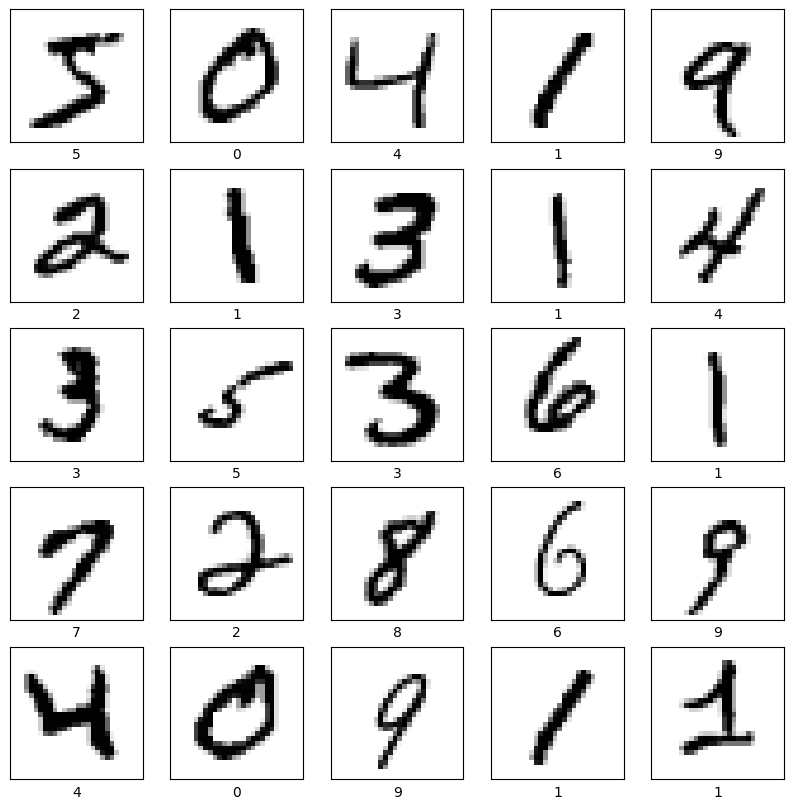

In [21]:
# Load dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Reshape the data to include the channel dimension
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Verify the data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

In [22]:
model = models.Sequential()
model.add(layers.Conv2D(6, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(10))

In [23]:
learning_rate = 0.01

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [24]:
logdir = "./logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch='500,520')


In [25]:
batch_size = 100  # Specify the batch size

history = model.fit(train_images, train_labels, epochs=3, 
                    batch_size=batch_size,
                    validation_data=(test_images, test_labels),
                    callbacks=[tensorboard_callback])


Epoch 1/3
600/600 [==============================] - 4s 5ms/step - loss: 0.1457 - accuracy: 0.9548 - val_loss: 0.0583 - val_accuracy: 0.9829
Epoch 2/3
600/600 [==============================] - 3s 5ms/step - loss: 0.0578 - accuracy: 0.9823 - val_loss: 0.0462 - val_accuracy: 0.9859
Epoch 3/3
600/600 [==============================] - 3s 5ms/step - loss: 0.0439 - accuracy: 0.9861 - val_loss: 0.0580 - val_accuracy: 0.9831


313/313 - 1s - loss: 0.0580 - accuracy: 0.9831 - 542ms/epoch - 2ms/step
0.9830999970436096


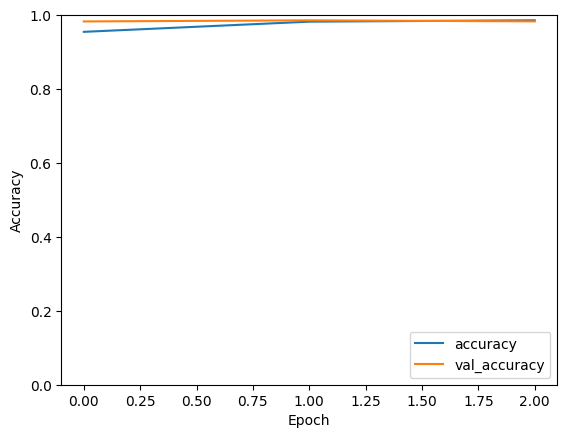

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(test_acc)